In [15]:
import torch
from torch import nn

import overcomplete
from overcomplete import *
from overcomplete.sae.base import SAE
import matplotlib.pyplot as plt

In [ ]:
#SAE definition
import torch
from torch import nn

from overcomplete.sae.base import SAE

class Sparsemax(nn.Module):
    def __init__(self, dim=-1):
        super(Sparsemax, self).__init__()
        self.dim = dim

    def forward(self, input):

        input_shifted = input - input.max(dim=self.dim, keepdim=True)[0]

        zs = torch.sort(input_shifted, dim=self.dim, descending=True)[0]
        zs_cumsum = zs.cumsum(dim=self.dim) - 1  # Subtract 1 as per the Sparsemax formula

        range_dim = zs.size(self.dim)
        rhos = torch.arange(1, range_dim + 1, device=input.device, dtype=input.dtype)
        rhos_shape = [1] * input.dim()
        rhos_shape[self.dim] = -1
        rhos = rhos.view(rhos_shape)

        support = zs > zs_cumsum / rhos
        k = support.sum(dim=self.dim, keepdim=True)

        tau_sum = zs_cumsum.gather(self.dim, k - 1)
        tau = tau_sum / k.type(input.dtype)
        tau = tau.expand_as(input)

        output = torch.clamp(input_shifted - tau, min=0)

        return output

def identity_encoder(x):
            return x, x
identity_module = nn.Module()
identity_module.forward = identity_encoder

class Spade(SAE):
    def __init__(self, input_shape, nb_concepts, top_k=None, threshold_momentum=0.9,
                 encoder_module=None, dictionary_params=None, device='cpu', nb_archetypes=None):

        super().__init__(input_shape, nb_concepts, identity_module,
                         dictionary_params, device)

        if nb_archetypes is None:
            nb_archetypes = nb_concepts

        self.nb_archetypes = nb_archetypes

        alphas = torch.randn(nb_archetypes, input_shape, device=device)
        self.alphas = torch.nn.Parameter(alphas, requires_grad=True)

        temperature = torch.tensor(0.0, device=device)
        self.temperature = torch.nn.Parameter(temperature, requires_grad=True)

        self.sparsemax = Sparsemax(dim=-1)

    def encode(self, x):
        pre_codes, _ = self.encoder(x)

        # distance as matrix multiplication
        a = pre_codes
        b = self.alphas

        a2 = (a ** 2).sum(dim=1, keepdim=True)
        b2 = (b ** 2).sum(dim=1, keepdim=True)
        ab = a @ b.T
        dist = a2 + b2.T - 2 * ab
        dist = dist

        # old distance
        #dist = torch.mean((pre_codes[:, None, :] - self.alphas[None, :, :]).square(), 2)

        codes = self.sparsemax(- torch.exp(self.temperature) * dist)

        return dist, codes


In [ ]:
torch.cuda.empty_cache()

#load results from vision experiments
data = torch.load('./results/vision_data_experiment2.pth')
data.keys()

/tmp/ipykernel_720717/1413876377.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('./results/vision_data_experiment2.pth')


dict_keys(['cls_tokens', 'z_spade', 'z_jump', 'z_topk', 'preds', 'spade_sae', 'alphas', 'jump_sae', 'topk_sae', 'vanilla_sae', 'z_vanilla'])

In [ ]:
# arrange data_subset and labels_subset to align with other experiments' analysis
data_subset_raw = data['cls_tokens']
labels_subset_raw = data['preds']
labels_order = torch.unique(labels_subset_raw)
numpoints_perconc = [(labels_subset_raw==lab).sum().item() for lab in labels_order]
data_subset = torch.zeros_like(data_subset_raw)
labels_subset = torch.zeros_like(labels_subset_raw)
cumsum = 0
indices_list = []
num_concepts = len(labels_order)
for i, lab in enumerate(labels_order):
    data_subset[cumsum: cumsum+numpoints_perconc[i],:] = data_subset_raw[labels_subset_raw==lab,:]
    labels_subset[cumsum: cumsum+numpoints_perconc[i]] = i
    indices_list.append((labels_subset_raw==lab).argwhere().squeeze().tolist())
    cumsum += numpoints_perconc[i]
#big list from the small lists in indices_list
indices_list_full = [item for sublist in indices_list for item in sublist]

In [19]:
alphas = data['alphas'].detach()

In [ ]:
#get sparse codes for each sae type
exptnames = ['relu', 'jumprelu', 'topk', 'spade']
saelatentnames = ['vanilla', 'jump', 'topk', 'spade']
latent_reps_all_raw = []
latent_reps_all = []
for sae in saelatentnames:
    latents = data['z_'+sae]
    latent_reps_all_raw.append(latents)
    latent_reps_all.append(latents[indices_list_full,:])

In [ ]:
#load trained weights, biases from each SAE
saenames_saved = ['vanilla_sae', 'jump_sae', 'topk_sae', 'spade_sae']
encweights = []
preencbias = []
for i, saename in enumerate(saenames_saved):
    if saename!='spade_sae':
        wts = data[saename].encoder.final_block[0].weight.detach().cpu()
        bias = data[saename].encoder.final_block[0].bias.detach().cpu()
        encweights.append(wts)
        preencbias.append(bias)
    else:
        wts = data[saename].alphas.detach().cpu()
        bias = None
        encweights.append(wts)
        preencbias.append(bias)


In [22]:
#identify concept which latent activates most for
classavg_reps = [torch.zeros(num_concepts, latent_reps_all[i].shape[-1]) for i in range(len(exptnames))]
for i in range(len(exptnames)):
    for c in range(num_concepts):
        classavg_reps[i][c] = torch.mean(latent_reps_all[i][labels_subset==c, :], dim=0)    
order_by_concept_all = []
concepts_of_latents_all = []
concepts_ordered_all = []
numlatents_perconc_all = []
for i in range(len(exptnames)):
    concepts_of_latents = torch.argmax(classavg_reps[i], dim=0) #gives indices of concepts with max value in each latent dimension
    order_by_concept = torch.argsort(concepts_of_latents) #sorts latents by concept
    order_by_concept_all.append(order_by_concept)
    concepts_of_latents_all.append(concepts_of_latents)
    concepts_ordered_all.append(concepts_of_latents[order_by_concept])
    numlatents_perconc_all.append([torch.sum(concepts_of_latents==c).item() for c in range(num_concepts)])


In [ ]:
#compute data-data and latent-latent similarities
Cdata_all = []
Clatent_all = []
for i in range(len(exptnames)):
    latents = latent_reps_all[i][:,order_by_concept_all[i]]
    deadlatents = (latents>1e-12).sum(dim=0)==0.0
    latents = torch.cat([latents[:,~deadlatents], latents[:,deadlatents]], dim=1)
    Corr = latents @ latents.T
    norm = torch.norm(latents, dim=1).unsqueeze(1)
    Cdata_all.append( Corr/ (norm @ norm.T + 1e-12) )
    
    Corr = latents.T @ latents
    norm = torch.norm(latents, dim=0).unsqueeze(1)
    Corr = Corr/ (norm @ norm.T + 1e-12)
    Clatent_all.append(Corr)

In [24]:
#pca of data_subset
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data_subset)
data_subset_pca = pca.transform(data_subset)
encweightspca_spade = pca.transform(alphas.numpy())

In [25]:
class_names = {
    574: "Golf ball",
    571: "Gas pump",
    569: "Garbage truck",
    0:   "Tench",
    701: "Parachute",
    217: "English Springer",
    566: "French horn",
    491: "Chainsaw",
    497: "Church",
    482: "Casette player"
}
concept_names = [class_names[lab.item()] for lab in labels_order]

In [87]:
#shorter concept names for plots- use only first 3 letters in each word
concept_names_short = [name.split()[0][:3]+"."+ " "+ name.split()[1][:3]+"." if len(name.split()) == 2 else name[:3]+"." for name in concept_names]

In [26]:
#pca of data_subset
from sklearn.decomposition import PCA
pca3 = PCA(n_components=3)
pca3.fit(data_subset)
data_subset_pca3 = pca3.transform(data_subset)
encweightspca_spade3 = pca3.transform(alphas.numpy())

In [27]:
# stableranks = []
# for i in range(len(exptnames)):
#     sr = torch.trace(Clatent_all[i])/torch.linalg.matrix_norm(Clatent_all[i], ord=2)
#     stableranks.append(sr.item())


In [ ]:
#get f1 score of each latent for each class
width = latent_reps_all[0].shape[-1]
saes_order = ['relu', 'jumprelu', 'topk_relu', 'sparsemax_dist']
#get f1 score of each latent for each class
eps = 1e-12

f1_all = torch.zeros((len(exptnames), num_concepts, width))
precision_all = torch.zeros((len(exptnames), num_concepts, width))
recall_all = torch.zeros((len(exptnames), num_concepts, width))
l0_all = torch.zeros((len(exptnames)))

for i in range(len(exptnames)):
    latents_i = latent_reps_all[i]
    # threshold = torch.quantile(latents_i[latents_i>0.0].flatten(), 0.1) #10th percentile of data
    threshold = 1e-6
    l0_all[i] = (latents_i>threshold).sum(dim=-1).float().mean()
    for c in range(num_concepts):
        truepos = (latents_i[labels_subset==c,:]>threshold).sum(0).float()
        falsepos = (latents_i[labels_subset!=c,:]>threshold).sum(0).float()
        allpos = (labels_subset==c).sum().float()
        pospred = (latents_i>threshold).sum(0).float()
        precision = truepos/(pospred+eps)
        recall = truepos/(allpos+eps)
        f1 = 2*precision*recall/(precision+recall+eps)
        f1_all[i,c, :] = f1
        precision_all[i,c, :] = precision
        recall_all[i,c, :] = recall
monosemantic_latents = torch.argmax(f1_all, dim=-1)

ordered_latents = torch.argsort(f1_all, dim=-1, descending=True)
f1_sorted = torch.gather(f1_all, dim=-1, index=ordered_latents)
precision_sorted = torch.gather(precision_all, dim=-1, index=ordered_latents)
recall_sorted = torch.gather(recall_all, dim=-1, index=ordered_latents)


In [29]:
#pca of data_subset
from sklearn.decomposition import PCA
pca3 = PCA(n_components=3)
pca3.fit(data_subset)
data_subset_pca3 = pca3.transform(data_subset)
encweightspca3 = [pca3.transform(encweights[i]) for i in range(len(exptnames))]
# preencbiaspca3 = [pca3.transform(preencbias[i].reshape((-1,1))) for i in range(len(exptnames)-1)]

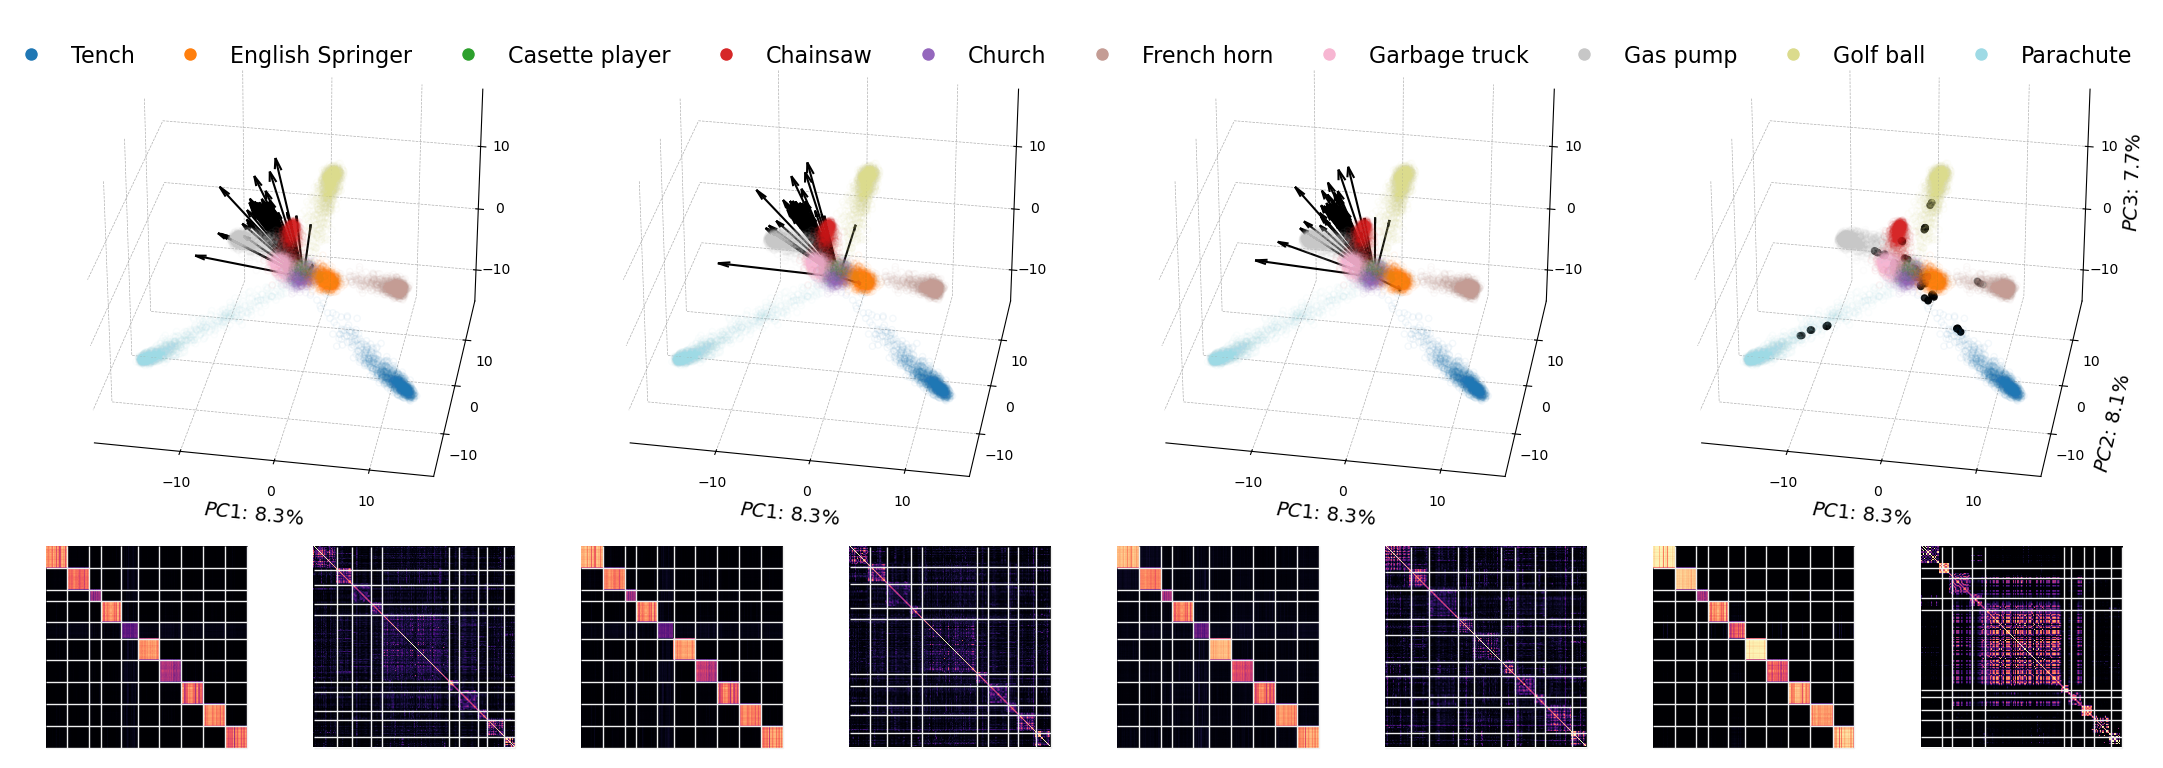

In [ ]:
# plot part of main figure for vision experiments
# 3DPCA of data with encoder weights and data-data and latent-latent similarities
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogLocator
import numpy as np

# Scaling factor for figure size
scaleval = 2.6  # Adjust this as needed
fig = plt.figure(figsize=(scaleval * 8.3, scaleval * 3))

# Define the GridSpec layout (5 rows, 8 columns)
gs = gridspec.GridSpec(3, 8, figure=fig, height_ratios=[1.2, 1.2, 1])

# Define subplots using GridSpec, mirroring the subplot2grid layout
ax1 = fig.add_subplot(gs[0:2, 0:2], projection='3d')
ax2 = fig.add_subplot(gs[0:2, 2:4], sharey=ax1, sharex=ax1, projection='3d')
ax3 = fig.add_subplot(gs[0:2, 4:6], sharey=ax1, sharex=ax1, projection='3d')
ax4 = fig.add_subplot(gs[0:2, 6:8], sharey=ax1, sharex=ax1, projection='3d')

ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 2])
ax7 = fig.add_subplot(gs[2, 4])
ax8 = fig.add_subplot(gs[2,6])

ax9 = fig.add_subplot(gs[2, 1])
ax10 = fig.add_subplot(gs[2, 3])
ax11 = fig.add_subplot(gs[2, 5])
ax12 = fig.add_subplot(gs[2, 7])

axes = np.array([[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, ax10, ax11, ax12]])
ax = axes.T


# fig, ax = plt.subplots(3, 4, figsize=(3*4, 3*3))
# ax = ax.T
# cmap = plt.cm.rainbow
# colors_concepts = [cmap.colors[i] for i in range(num_concepts)]
# get 10 colors from a colormap
cmap = plt.get_cmap('tab20')
# scales_all = [1, 100,100, -1]
lengthsall = [20, 20, 20, -1]

# Generate 10 evenly spaced colors
colors_concepts = [cmap(i) for i in np.linspace(0, 1, num_concepts)]
# pos_colors = {
#     'Noun': [1.        , 0.41176471, 0.70588235], 
#     'Pro.': [0.66666667, 0.52418301, 0.80392157], 
#     'Verb': [0.        , 0.74901961, 1. ], 
#     'Adv.': [0.33333333, 0.63660131, 0.90196078], 
#     'Adj.': [0.5882352941176471, 0.4627450980392157, 0.3843137254901961], 
#     'Conj.': [0.7, 0.7, 0.7], 
#     }
# colors_concepts = [pos_colors[concept_names[i]] for i in range(num_concepts)]
elev = 30
azim = -80
for i in range(len(exptnames)):
    if i==len(exptnames)-1:

        #plot 3D-PCA of data
        ax[i,0].scatter(data_subset_pca3[:,0], data_subset_pca3[:,1], data_subset_pca3[:,2], \
        edgecolors=[colors_concepts[int(labels_subset[i].item())] for i in range(len(labels_subset))], s=20, alpha=0.05, facecolors='none')
        
        #plot encoder weights as scatter plot for SpaDE
        ax[i,0].scatter(encweightspca3[i][:,0], encweightspca3[i][:,1], encweightspca3[i][:,2], c='black', s=20)
        ax[i,0].view_init(elev=elev, azim=azim)
    else:

        #plot encoder weights as quivers for ReLU, JumpReLU and TopK
        ax[i,0].quiver(torch.zeros((encweightspca3[i].shape[0],)), \
            torch.zeros((encweightspca3[i].shape[0],)), \
                torch.zeros((encweightspca3[i].shape[0],)), \
                    encweightspca3[i][:,0], encweightspca3[i][:,1], encweightspca3[i][:,2], \
                        color='black', length=lengthsall[i], arrow_length_ratio=0.1)
        
        #plot 3D-PCA of data
        ax[i,0].scatter(data_subset_pca3[:,0], data_subset_pca3[:,1], data_subset_pca3[:,2], \
        edgecolors=[colors_concepts[int(labels_subset[i].item())] for i in range(len(labels_subset))], s=20, alpha=0.05, facecolors='none')
        ax[i,0].view_init(elev=elev, azim=azim)
    # ax[i,0].yaxis.set_rotate_label(False)
    # ax[i,0].xaxis.set_rotate_label(False)
    # ax[i,0].zaxis.set_rotate_label(False)
    
    if i==3:
        ax[i,0].set_zlabel(r'$PC3$: '+f"{pca3.explained_variance_ratio_[2]*100:.1f}" + '%', fontsize=14, labelpad=5)
        ax[i,0].set_ylabel(r'$PC2$: '+f"{pca3.explained_variance_ratio_[1]*100:.1f}" + '%', fontsize=14, labelpad=10)
    ax[i,0].set_xlabel(r'$PC1$: '+f"{pca3.explained_variance_ratio_[0]*100:.1f}" + '%', fontsize=14, labelpad=5)

    #plot data and latent correlations using sparse codes
    ax[i, 1].imshow(Cdata_all[i].detach().cpu(), cmap='magma', vmin=0, vmax=1)
    ax[i,1].hlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[1], colors='#EFEFEF', linewidth=1)
    ax[i,1].vlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[0], colors='#EFEFEF', linewidth=1)
    ax[i, 2].imshow(Clatent_all[i].detach().cpu(), cmap='magma', vmin=0, vmax=1)
    ax[i,2].hlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[1], colors='#EFEFEF', linewidth=1)
    ax[i,2].vlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[0], colors='#EFEFEF', linewidth=1)
    # ax[i,0].set_xticks([])
    # ax[i,0].set_yticks([])
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    # ax[i,1].set_xticks([])
    # ax[i,1].set_yticks([])
    # ax[i,2].set_xticks([])
    # ax[i,2].set_yticks([])
    if i==0:
        # add custom legend with points with concept names and colors
        custom_points = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_concepts[c], markersize=10) for c in range(num_concepts)]
        fig.legend(custom_points, concept_names, frameon=False, loc=[0, 0.9], fontsize=16, ncol=10, mode='expand')

# for i in range(ax.shape[0]):
#     ax[i,0].set_xscale('log')
#     ax[i,0].set_yscale('log')
#     ax[i,0].set_zscale('log')

for i in range(ax.shape[0]):
    # ax[i,0].set_xscale('log')
    # ax[i,0].set_yscale('log')
    # ax[i,0].set_zscale('log')

    # Make gridlines thinner and lighter
    ax[i,0].xaxis._axinfo["grid"].update({"linewidth":0.5, "linestyle":'--'})
    ax[i,0].yaxis._axinfo["grid"].update({"linewidth":0.5, "linestyle":'--'})
    ax[i,0].zaxis._axinfo["grid"].update({"linewidth":0.5, "linestyle":'--'})

    # Remove background color
    ax[i,0].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax[i,0].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax[i,0].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Put fewer ticks
    ax[i,0].locator_params(axis='x', nbins=4)
    ax[i,0].locator_params(axis='y', nbins=4)
    ax[i,0].locator_params(axis='z', nbins=4)
    # ax[i,0].xaxis.set_major_locator(LogLocator(base=10.0, numticks=4))  # Adjust number of ticks
    # ax[i,0].yaxis.set_major_locator(LogLocator(base=10.0, numticks=4))
    # ax[i,0].zaxis.set_major_locator(LogLocator(base=10.0, numticks=4))

    

# for axy in axes.flatten():
#     axy.spines['top'].set_visible(False)
#     axy.spines['right'].set_visible(False)

# fig.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)

plt.tight_layout()
# plt.savefig('./figs/visionmainfig.pdf',dpi=300,bbox_inches='tight')

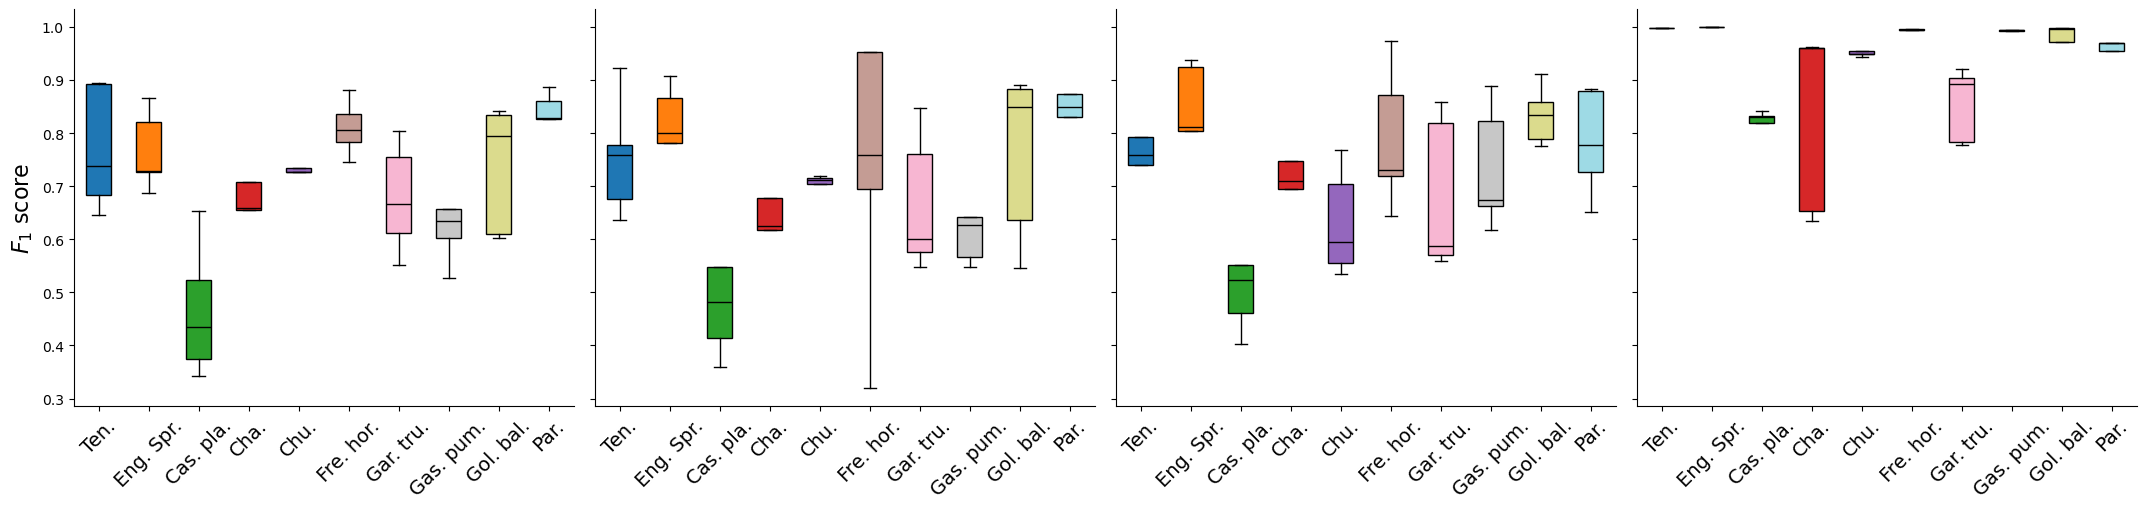

In [ ]:
#plot f1 scores of all classes for each sae type
saenames_plot = ['ReLU', 'JumpReLU', 'TopK', 'SpaDE']
scaleval = 2.6
fig, ax = plt.subplots(1, 4, figsize=(scaleval*8.3,scaleval*2), sharey=True)
shownum = 5
for i in range(len(exptnames)):
    bplot = ax[i].boxplot([f1_sorted[i, c, :shownum].detach().cpu().numpy() for c in range(num_concepts)], \
        patch_artist=True, showfliers=False)
    for patch, color in zip(bplot['boxes'], colors_concepts):
        # patch.set_edgecolor(color)
        patch.set_facecolor(color)
        # patch.set_alpha(0.5)
    # for patch, color in zip(bplot['whiskers'], colors_concepts):
    #     patch.set_color(color)
    # for patch, color in zip(bplot['caps'], colors_concepts):
    #     patch.set_color(color)
        
    for j, median in enumerate(bplot['medians']):
        median.set_color('k')
    ax[i].set_xticks(range(1, num_concepts + 1))
    ax[i].set_xticklabels(concept_names_short, rotation=45, fontsize=14)
    # ax[i].set_title(saenames_plot[i], fontsize=16)
    if i==0:
        ax[i].set_ylabel(r'$F_1$ score', fontsize=16, labelpad=5)

for axis in ax:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig('./figs/visionmainfig_f1.pdf',dpi=300,bbox_inches='tight')
